# TP3 Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
template_path = 'TP3/template/pattern.png'
img_path = 'TP3/images/'


Tamaño original: (175, 400)


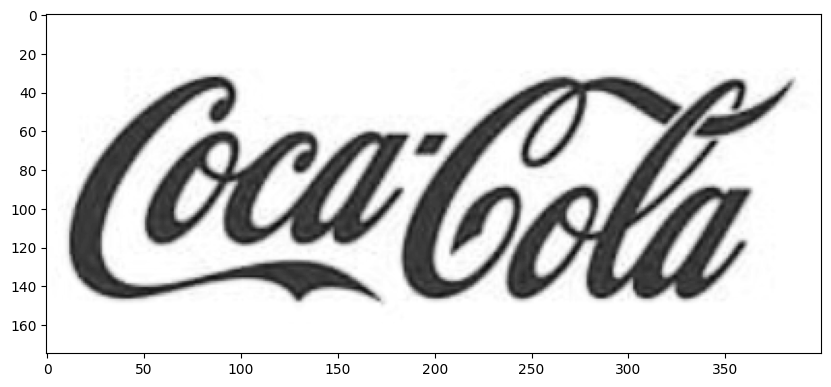

In [3]:
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
print(f'Tamaño original: {template.shape}')
_,ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(template, cmap='gray')


In [4]:
def detect_template(img, template, threshold = None):
    '''
    Función para detectar un template en una imagen.
    Parámetros:
        img: imagen original
        template: template a buscar
        threshold: umbral para la detección de múltiples matches (opcional). Rango [0,1]
    Retorna:
        matches: lista de matches o un match (según el parámetro threshold). 
        Cada elemento tiene la siguiente estructura (score, top_left, bottom_right, scale)
        best_pattern: mejor template encontrado

    '''
    #Transformo la imagen a escala de grises
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #Detecto los bordes
    edges_template = cv.Canny(template, 120, 240, L2gradient=True)

    
    max_scale = 4 # Factor maximo de ampliacion de la imagen
    min_scale = max (template.shape[0] / img.shape[0], template.shape[1] / img.shape[1]) # Factor minimo de escalado la imagen
    #Genero una lista de escalas 
    scales = np.linspace(min_scale, max_scale, 100)
 
    best_match = None #Mejor match 
    matches = [] #Lista de matches
    for scale in scales:
        #Escalo la imagen en vez del template para evitar perder definicion en el template
        img_scaled = cv.resize(img, (0,0),fx=scale,fy=scale, interpolation= cv.INTER_LINEAR)
        #Detecto los bordes
        edges_scaled = cv.Canny(img_scaled, 100, 200, L2gradient=True)
        
        #Aplico la correlacion
        if edges_template.shape[0] < edges_scaled.shape[0] and edges_template.shape[1] < edges_scaled.shape[1]:    
            result = cv.matchTemplate(edges_scaled, edges_template, cv.TM_CCOEFF)

            #Mejor match para la escala actual
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
            top_left = max_loc
            score = max_val
            w, h = edges_template.shape[::-1]

            #Si se especifico un threshold, busco todos los matches mayores a threshold*max_val en esta escala           
            if threshold is not None:
                locs = np.where( result >= threshold*max_val)
                for loc in zip (*locs[::-1]):
                    matches.append((result[loc[1],loc[0]],(loc[0],loc[1]) , (loc[0]+w,loc[1]+h), scale))
            #Si no, guardo el mejor match
            if best_match is None or score > best_match[0]:
                bottom_right = (max_loc[0] + w, max_loc[1] + h)
                best_match = (score, top_left, bottom_right, scale)
                best_pattern = edges_template
  
    if threshold is not None:
        best_match = max(matches, key=lambda x: x[0]) #busco el mejor match
        matches = list(filter(lambda x: x[0] >= threshold*best_match[0], matches)) #filtro los matches por threshold
        matches = sorted(matches, key=lambda x: x[0], reverse=True) #ordeno los matches por score
        return matches, best_pattern
    else:
        return best_match, best_pattern


In [5]:
def plot_results (img, matches, template):
    '''
    Función para graficar los resultados de la detección de patrones.
    Parámetros:
        img: imagen original
        matches: lista de matches o un match
        template: template que se buscó
    '''    
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    if isinstance(matches[0], float):#Si el primer elemento es un float, es un solo match
        scale = matches[3]
        up_left = round (matches[1][0]/scale), round (matches[1][1]/scale)
        down_right = round (matches[2][0]/scale), round (matches[2][1]/scale)
        cv.rectangle(img,up_left, down_right, (0,255,0), 2)
        
    else:   #Si no, es una lista de matches
        for match in matches:
            scale = match[3]
            up_left = round (match[1][0]/scale), round (match[1][1]/scale)
            down_right = round (match[2][0]/scale), round (match[2][1]/scale)
            cv.rectangle(img,up_left, down_right, (0,255,0), 2)

    #Creo un plot
    _,ax = plt.subplots(1,2,figsize=(10,10))
    ax[0].imshow(template, cmap='gray')
    ax[0].set_title('Template')
    ax[1].imshow(img)
    ax[1].set_title('Match/es')

# 1 y 3 Deteccion simple

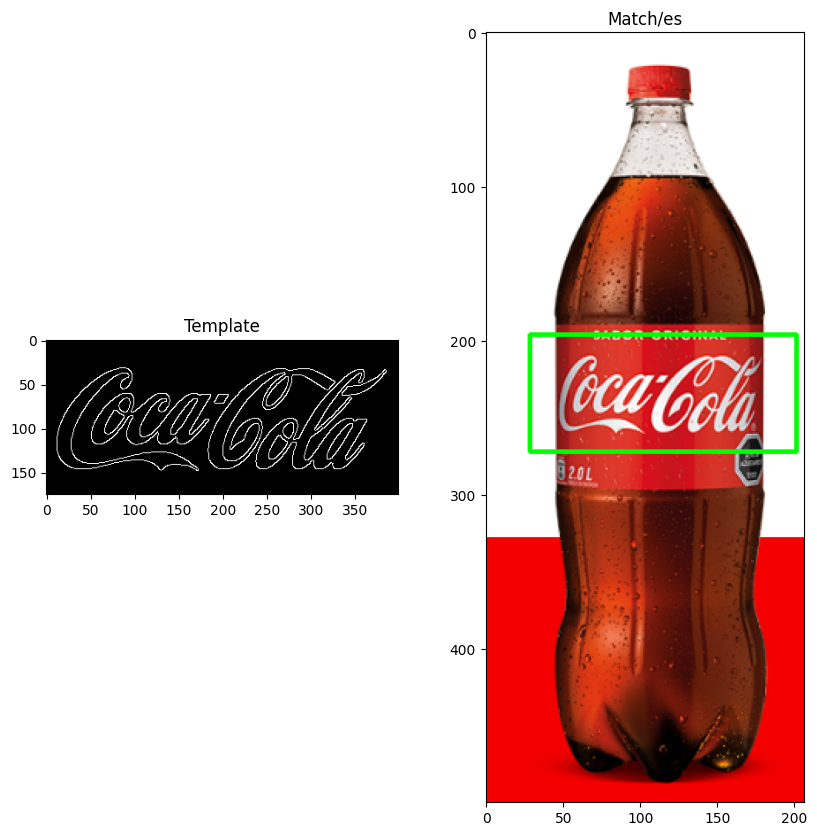

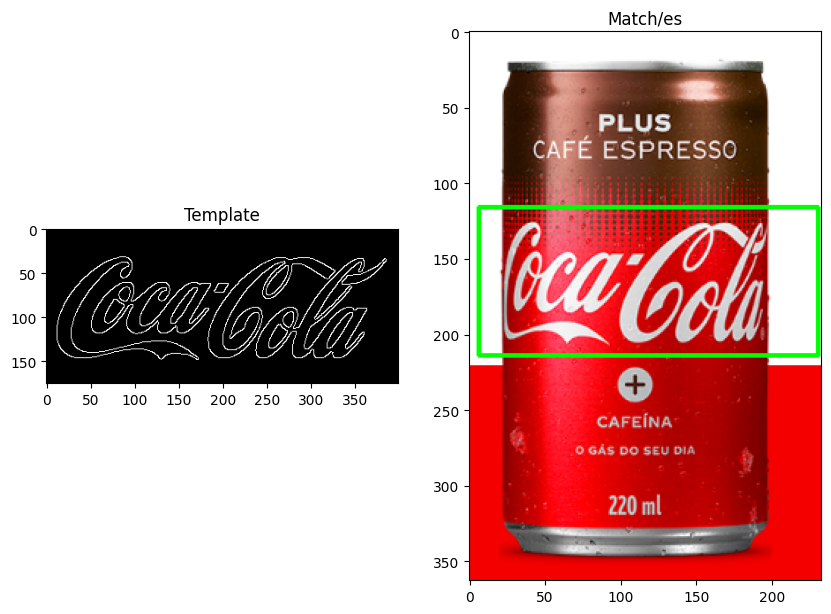

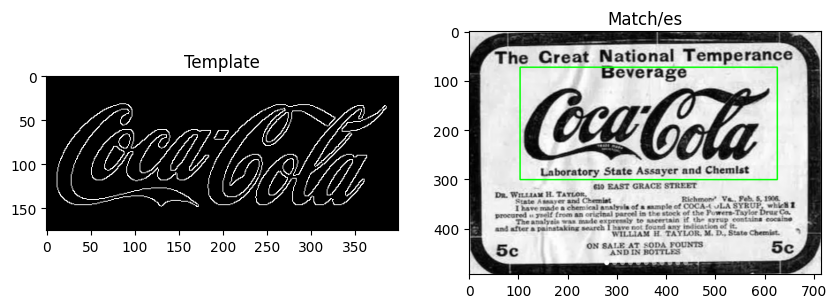

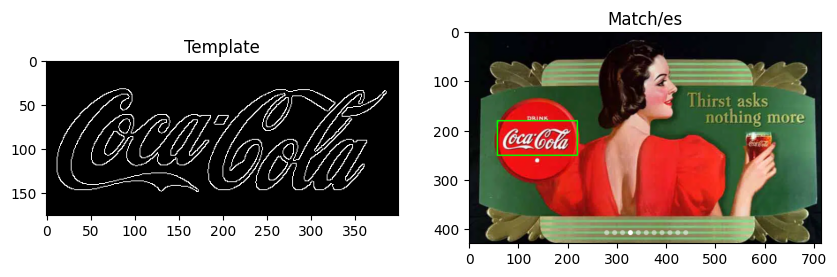

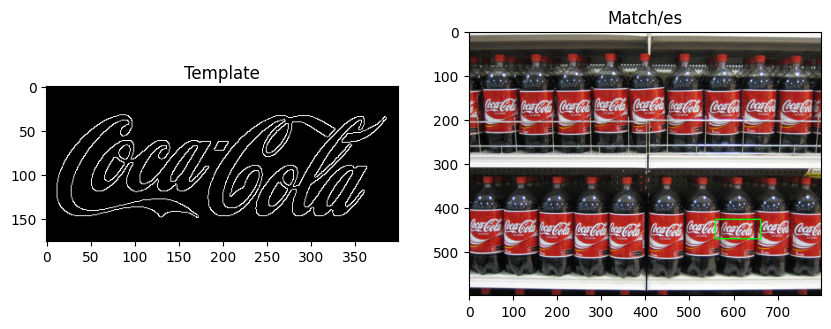

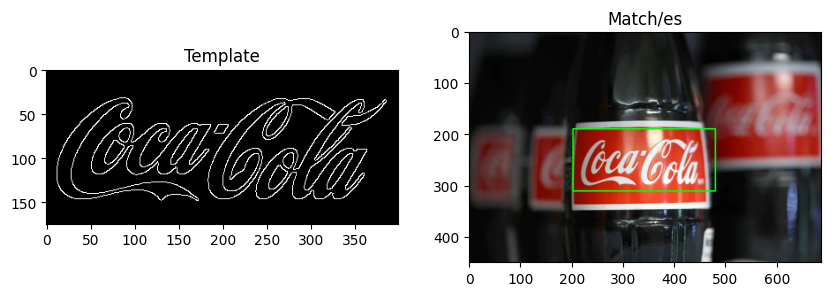

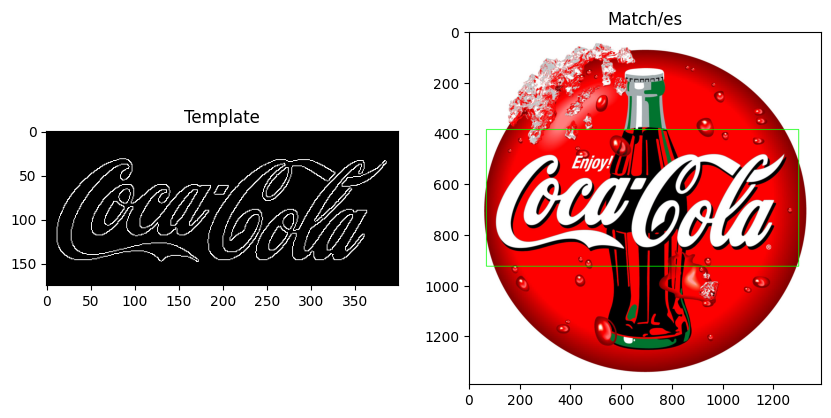

In [6]:
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)

image_names = ['coca_logo_1.png','coca_logo_2.png','coca_retro_1.png', 'coca_retro_2.png','coca_multi.png','logo_1.png', 'COCA-COLA-LOGO.jpg']

for i, image_name in enumerate (image_names):
    img = cv.imread(img_path+image_name)
    matches, best_pattern = detect_template(img, template) # No especifico un threshold, por lo que solo se detecta el mejor match
    plot_results (img, matches, best_pattern)

# 2 y 3 Deteccion multiple

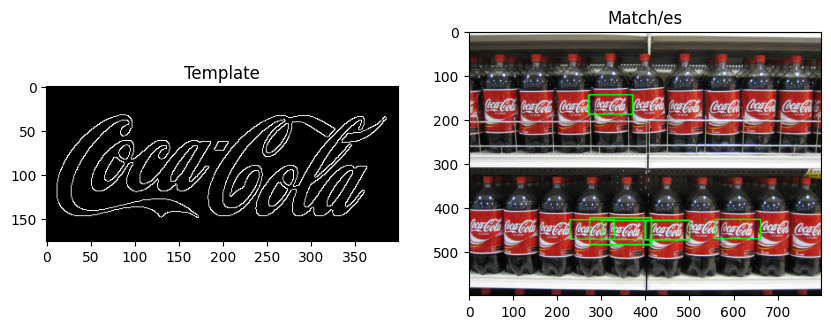

In [7]:
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)

image_names = ['coca_multi.png']

for i, image_name in enumerate (image_names):
    img = cv.imread(img_path+image_name)
    matches, best_pattern = detect_template(img, template, threshold = 0.9) # Especifico un threshold, por lo que se detectan todos los matches mayores a threshold*max_val
    plot_results (img, matches, best_pattern)

Se lograron detectar algunas de las botellas sin error. Se podrian hacer mas detecciones si se baja el umbral de deteccion, pero se generarian mas falsos positivos.